In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [2]:
data = pd.read_csv(r'data/housing.csv')

In [3]:
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor
from sklearn.feature_extraction import DictVectorizer
# Keep only the records where ocean_proximity is either '<1H OCEAN' or 'INLAND'
data = data[data['ocean_proximity'].isin(['<1H OCEAN', 'INLAND'])]

# Fill missing values with zeros
data.fillna(0, inplace=True)

# Apply the log transform to median_house_value
data['median_house_value'] = data['median_house_value'].apply(lambda x: 0 if x <= 0 else np.log(x))

# Do train/validation/test split with 60%/20%/20% distribution
df_full_train, df_test = train_test_split(data, test_size=0.2, random_state=1)
df_train, df_val = train_test_split(df_full_train, test_size=0.25, random_state=1)  # 0.25 * 0.8 = 0.2

# Separate the target variable
y_train = df_train['median_house_value'].values
y_val = df_val['median_house_value'].values
y_test = df_test['median_house_value'].values

# Drop the target variable from the training/validation/test sets
del df_train['median_house_value']
del df_val['median_house_value']
del df_test['median_house_value']

# Use DictVectorizer to turn the dataframes into matrices
dicts_train = df_train.to_dict(orient='records')
dicts_val = df_val.to_dict(orient='records')
dicts_test = df_test.to_dict(orient='records')

dv = DictVectorizer(sparse=True)
X_train = dv.fit_transform(dicts_train)
X_val = dv.transform(dicts_val)
X_test = dv.transform(dicts_test)

# Train a Decision Tree Regressor with max_depth=1
dt = DecisionTreeRegressor(max_depth=1)
dt.fit(X_train, y_train)

# Identify which feature is used for splitting the data
split_feature = dv.feature_names_[dt.tree_.feature[0]]
print(split_feature)

ocean_proximity=INLAND


In [4]:
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

# Train a Random Forest model with the given parameters
rf = RandomForestRegressor(n_estimators=10, random_state=1, n_jobs=-1)
rf.fit(X_train, y_train)

# Predict on the validation set
y_pred = rf.predict(X_val)

# Calculate RMSE on validation
rmse = np.sqrt(mean_squared_error(y_val, y_pred))
print(rmse)


0.2454364295869227


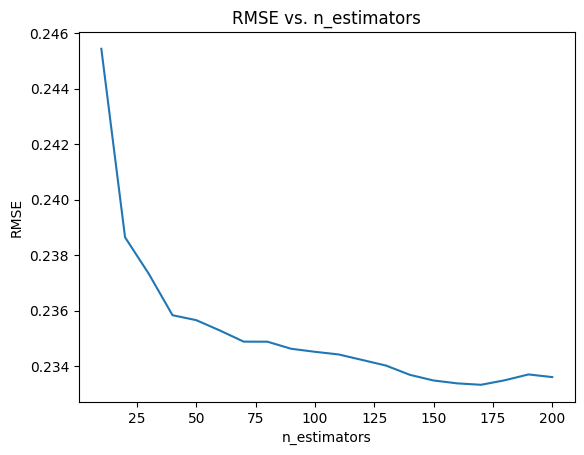

RMSE stops improving after n_estimators = 50


In [5]:
import matplotlib.pyplot as plt

estimators = list(range(10, 201, 10))
scores = []

for n in estimators:
    rf = RandomForestRegressor(n_estimators=n, random_state=1, n_jobs=-1)
    rf.fit(X_train, y_train)
    
    y_pred = rf.predict(X_val)
    rmse = np.sqrt(mean_squared_error(y_val, y_pred))
    scores.append(rmse)

# Plot RMSE values to visualize
plt.plot(estimators, scores)
plt.xlabel('n_estimators')
plt.ylabel('RMSE')
plt.title('RMSE vs. n_estimators')
plt.show()

# Find the estimator after which RMSE stops improving
delta = 0.001  # Considering 3 decimal places
for i in range(1, len(scores)):
    if abs(scores[i] - scores[i-1]) < delta:
        print(f'RMSE stops improving after n_estimators = {estimators[i]}')
        break


In [6]:
max_depth_values = [10, 15, 20, 25]
mean_rmse_values = []

for depth in max_depth_values:
    rmses = []
    for n in range(10, 201, 10):
        rf = RandomForestRegressor(n_estimators=n, max_depth=depth, random_state=1, n_jobs=-1)
        rf.fit(X_train, y_train)

        y_pred = rf.predict(X_val)
        rmse = np.sqrt(mean_squared_error(y_val, y_pred))
        rmses.append(rmse)

    mean_rmse_values.append(np.mean(rmses))

# Determine the best max_depth using the mean RMSE
best_max_depth = max_depth_values[np.argmin(mean_rmse_values)]
print(f"The best max_depth using the mean RMSE is: {best_max_depth}")


The best max_depth using the mean RMSE is: 20


In [7]:
# Train the Random Forest model with the specified parameters
rf = RandomForestRegressor(n_estimators=10, max_depth=20, random_state=1, n_jobs=-1)
rf.fit(X_train, y_train)

# Extract feature importance
importances = rf.feature_importances_
feature_importance_dict = dict(zip(dv.feature_names_, importances))

# Extract the importance of the specific features
specific_features = ['total_rooms', 'median_income', 'total_bedrooms', 'longitude']
specific_importances = {feature: feature_importance_dict[feature] for feature in specific_features}

# Find the most important feature among the given ones
most_important_feature = max(specific_importances, key=specific_importances.get)
print(f"The most important feature among the provided ones is: {most_important_feature}")


The most important feature among the provided ones is: median_income


In [8]:
import xgboost as xgb

# Convert datasets to DMatrix
dtrain = xgb.DMatrix(X_train, label=y_train)
dval = xgb.DMatrix(X_val, label=y_val)

# Create watchlist
watchlist = [(dtrain, 'train'), (dval, 'val')]

# Train with eta = 0.3
xgb_params = {
    'eta': 0.3,
    'max_depth': 6,
    'min_child_weight': 1,

    'objective': 'reg:squarederror',
    'nthread': 8,

    'seed': 1,
    'verbosity': 1,
}
model_03 = xgb.train(xgb_params, dtrain, num_boost_round=100, evals=watchlist, verbose_eval=10)

# Predict on validation and calculate RMSE
y_pred_03 = model_03.predict(dval)
rmse_03 = np.sqrt(mean_squared_error(y_val, y_pred_03))

# Train with eta = 0.1
xgb_params['eta'] = 0.1
model_01 = xgb.train(xgb_params, dtrain, num_boost_round=100, evals=watchlist, verbose_eval=10)

# Predict on validation and calculate RMSE
y_pred_01 = model_01.predict(dval)
rmse_01 = np.sqrt(mean_squared_error(y_val, y_pred_01))

# Compare RMSEs
print(f"RMSE with eta=0.3: {rmse_03}")
print(f"RMSE with eta=0.1: {rmse_01}")

if abs(rmse_03 - rmse_01) < 1e-5:
    print("Both give equal value.")
elif rmse_03 < rmse_01:
    print("eta=0.3 gives the best RMSE.")
else:
    print("eta=0.1 gives the best RMSE.")


[0]	train-rmse:0.44351	val-rmse:0.44250
[10]	train-rmse:0.21445	val-rmse:0.25179
[20]	train-rmse:0.18524	val-rmse:0.23978
[30]	train-rmse:0.16888	val-rmse:0.23571
[40]	train-rmse:0.15542	val-rmse:0.23319
[50]	train-rmse:0.14536	val-rmse:0.23225
[60]	train-rmse:0.13719	val-rmse:0.23139
[70]	train-rmse:0.12943	val-rmse:0.23068
[80]	train-rmse:0.12192	val-rmse:0.22886
[90]	train-rmse:0.11504	val-rmse:0.22877
[99]	train-rmse:0.11043	val-rmse:0.22873
[0]	train-rmse:0.52449	val-rmse:0.52045
[10]	train-rmse:0.30326	val-rmse:0.31427
[20]	train-rmse:0.24512	val-rmse:0.26882
[30]	train-rmse:0.21887	val-rmse:0.25267
[40]	train-rmse:0.20392	val-rmse:0.24539
[50]	train-rmse:0.19215	val-rmse:0.24020
[60]	train-rmse:0.18457	val-rmse:0.23791
[70]	train-rmse:0.17741	val-rmse:0.23622
[80]	train-rmse:0.17242	val-rmse:0.23454
[90]	train-rmse:0.16798	val-rmse:0.23332
[99]	train-rmse:0.16323	val-rmse:0.23209
RMSE with eta=0.3: 0.22873152041427697
RMSE with eta=0.1: 0.23209114290057498
eta=0.3 gives the best